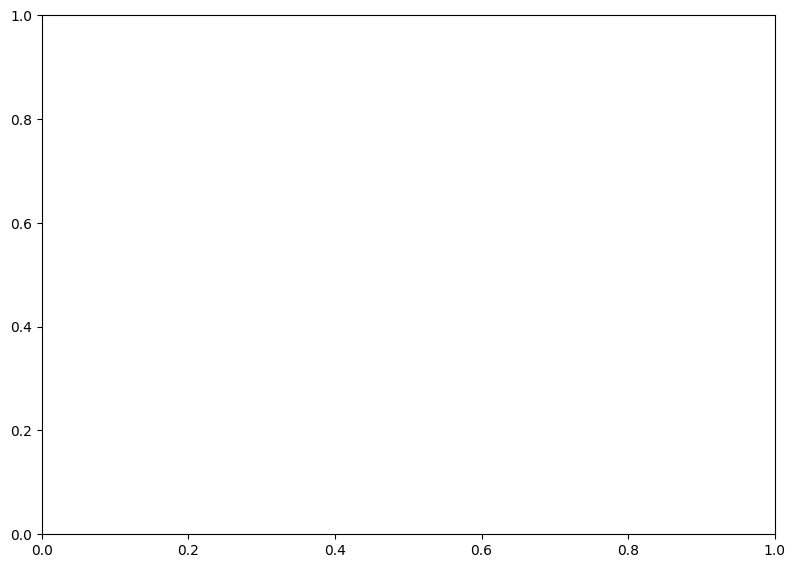

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
from algebra_operations import Algebra

class AlgebraGUI:
    def __init__(self, root):
        self.algebra = Algebra()
        self.root = root
        self.root.title("Algebra Calculator with Graph")
        self.root.geometry("950x700")

        self.tab_control = ttk.Notebook(root)
        self.input_tab = ttk.Frame(self.tab_control)
        self.graph_tab = ttk.Frame(self.tab_control)

        self.tab_control.add(self.input_tab, text='Input & Result')
        self.tab_control.add(self.graph_tab, text='Graph')
        self.tab_control.pack(expand=1, fill='both')

        # Method selector
        ttk.Label(self.input_tab, text="Select Algebra Method:").pack(pady=5)
        self.method_selector = ttk.Combobox(self.input_tab, values=[
            "Solve Inequality",
            "Find Vertex",
            "Find Axis Intersections",
            "Solve Linear System",
            "Solve Linear Inequality"
        ])
        self.method_selector.current(0)
        self.method_selector.pack(pady=5)
        self.method_selector.bind("<<ComboboxSelected>>", self.update_description)

        self.description_label = ttk.Label(self.input_tab, text="Enter expression or values")
        self.description_label.pack(pady=5)

        self.entry = ttk.Entry(self.input_tab, width=70, font=("Courier", 14))
        self.entry.pack(pady=5)

        self.keyboard_frame = ttk.Frame(self.input_tab)
        self.keyboard_frame.pack(pady=10)

        self.create_virtual_keyboard()

        self.solve_button = ttk.Button(self.input_tab, text="Solve", command=self.solve)
        self.solve_button.pack(pady=10)

        self.equation_label = ttk.Label(self.input_tab, text="Equation: ", font=("Helvetica", 10))
        self.equation_label.pack(pady=2)

        self.original_label = ttk.Label(self.input_tab, text="Original: ", font=("Helvetica", 10))
        self.original_label.pack(pady=2)

        self.standard_label = ttk.Label(self.input_tab, text="Standard Form: ", font=("Helvetica", 10))
        self.standard_label.pack(pady=2)

        self.solution_label = ttk.Label(self.input_tab, text="Solution: ", font=("Helvetica", 12, "bold"))
        self.solution_label.pack(pady=10)

        # Graph setup
        self.fig, self.ax = plt.subplots(figsize=(5, 4))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.graph_tab)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def create_virtual_keyboard(self):
        keys = [
            ["1", "2", "3", "+", "−"],
            ["4", "5", "6", "×", "÷"],
            ["7", "8", "9", "^", "√"],
            ["0", "x", "y", "=", "<", ">"],
            ["≤", "≥", "(", ")", "."]
        ]

        for r, row in enumerate(keys):
            for c, key in enumerate(row):
                b = ttk.Button(self.keyboard_frame, text=key, width=4, command=lambda k=key: self.insert_key(k))
                b.grid(row=r, column=c, padx=2, pady=2)

    def insert_key(self, key):
        self.entry.insert(tk.END, key)

    def update_description(self, event=None):
        self.description_label.config(
            text="Enter expression manually or using keyboard. Example: x^2 - 4x + 4 < 0"
        )

    def solve(self):
        from sympy import symbols, Eq, solveset, S, sympify, Poly
        x, y = symbols('x y')
        expr_input = self.entry.get().replace("−", "-").replace("×", "*").replace("÷", "/")

        try:
            if any(op in expr_input for op in ['<', '<=', '>', '>=']):
                for op in ['<=', '>=', '<', '>']:
                    if op in expr_input:
                        parts = expr_input.split(op)
                        left_expr = sympify(parts[0].strip())
                        right_expr = sympify(parts[1].strip())
                        inequality = f"{left_expr} {op} {right_expr}"
                        break
                self.equation_label.config(text=f"Equation: {inequality}")
                self.original_label.config(text="")
                self.standard_label.config(text="")
                self.solution_label.config(text=f"Solution: Expression parsed successfully.")

                x_vals = np.linspace(-10, 10, 400)
                y_vals = [left_expr.subs(x, val) - right_expr.subs(x, val) for val in x_vals]

                self.ax.clear()
                self.ax.plot(x_vals, y_vals, label=f"y = Left - Right")
                self.ax.axhline(0, color='black', linewidth=0.5)
                if '<' in expr_input:
                    self.ax.fill_between(x_vals, y_vals, 0, where=(np.array(y_vals) < 0), interpolate=True, alpha=0.3)
                elif '>' in expr_input:
                    self.ax.fill_between(x_vals, y_vals, 0, where=(np.array(y_vals) > 0), interpolate=True, alpha=0.3)
                self.ax.set_title("Parsed Inequality Graph")
                self.ax.legend()
                self.canvas.draw()
                self.tab_control.select(self.graph_tab)

            else:
                eq = sympify(expr_input)
                solution = solveset(Eq(eq, 0), x, domain=S.Reals)
                self.equation_label.config(text=f"Equation: {eq} = 0")

                poly = Poly(eq, x)
                coeffs = poly.all_coeffs()

                if len(coeffs) == 3:
                    a, b, c = [float(c) for c in coeffs]
                    vertex = self.algebra.find_vertex(a, b, c)
                    intersections = self.algebra.find_axis_intersections(a, b, c)
                    self.original_label.config(text=f"Vertex: {vertex}")
                    self.standard_label.config(text=f"Intersections: X: {intersections['x_axis']}, Y: {intersections['y_axis']}")

                    x_vals = np.linspace(vertex[0] - 10, vertex[0] + 10, 400)
                    y_vals = a * x_vals**2 + b * x_vals + c

                    self.ax.clear()
                    self.ax.plot(x_vals, y_vals, label=f"y = {eq}")
                    self.ax.plot(vertex[0], vertex[1], 'ro', label=f"Vertex {vertex}")
                    if intersections['x_axis']:
                        self.ax.plot(intersections['x_axis'][0], 0, 'go', label="X1")
                        self.ax.plot(intersections['x_axis'][1], 0, 'go', label="X2")
                    self.ax.plot(0, intersections['y_axis'], 'bo', label="Y")
                    self.ax.set_title("Graph of Quadratic")
                    self.ax.legend()
                    self.canvas.draw()
                    self.tab_control.select(self.graph_tab)
                else:
                    x_vals = np.linspace(-10, 10, 400)
                    y_vals = [float(eq.subs(x, val)) for val in x_vals]

                    self.original_label.config(text="Vertex: Not available for non-quadratic")
                    self.standard_label.config(text="Intersections: Not available")

                    self.ax.clear()
                    self.ax.plot(x_vals, y_vals, label=f"y = {eq}")
                    self.ax.axhline(0, color='black', linewidth=0.5)
                    self.ax.set_title("Graph of Expression")
                    self.ax.legend()
                    self.canvas.draw()
                    self.tab_control.select(self.graph_tab)

                self.solution_label.config(text=f"Solution: {solution}")
        except Exception as e:
            messagebox.showerror("Error", f"Could not parse expression: {e}")


if __name__ == "__main__":
    root = tk.Tk()
    app = AlgebraGUI(root)
    root.mainloop()
